In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings 
import keras.layers
import os
import cv2

In [2]:
train_labels = os.listdir('../input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/train')
print(train_labels)

#f= '../input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/train'
train = '../input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/train'

['PNEUMONIA', 'NORMAL']


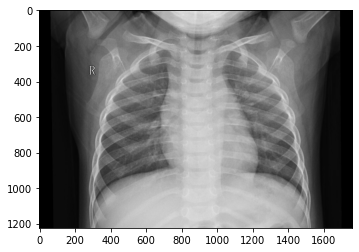

In [3]:
plt.imshow(cv2.imread('../input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/test/NORMAL/NORMAL2-IM-0035-0001.jpeg'))

In [4]:
dict = { "NORMAL" : 0, "PNEUMONIA" : 1}

In [5]:
normal = os.listdir('../input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/train/NORMAL')
print(normal)

['IM-0101-0001.jpeg', 'IM-0013-0001.jpeg', 'IM-0103-0001.jpeg', 'IM-0009-0001.jpeg', 'IM-0091-0001.jpeg', 'IM-0070-0001.jpeg', 'IM-0059-0001.jpeg', 'IM-0097-0001.jpeg', 'IM-0015-0001.jpeg', 'NORMAL2-IM-0027-0001.jpeg', 'IM-0041-0001.jpeg', 'IM-0084-0001.jpeg', 'IM-0029-0001.jpeg', 'IM-0081-0001.jpeg', 'IM-0110-0001.jpeg', 'IM-0035-0001.jpeg', 'IM-0105-0001.jpeg', 'IM-0021-0001.jpeg', 'NORMAL2-IM-0033-0001.jpeg', 'IM-0033-0001-0002.jpeg', 'NORMAL2-IM-0012-0001.jpeg', 'NORMAL2-IM-0028-0001.jpeg', 'IM-0022-0001.jpeg', 'NORMAL2-IM-0030-0001.jpeg', 'NORMAL2-IM-0007-0001.jpeg', 'IM-0003-0001.jpeg', 'IM-0107-0001.jpeg', 'IM-0017-0001.jpeg', 'IM-0006-0001.jpeg', 'IM-0043-0001.jpeg', 'IM-0061-0001.jpeg', 'IM-0111-0001.jpeg', 'IM-0102-0001.jpeg', 'IM-0071-0001.jpeg', 'IM-0001-0001.jpeg', 'IM-0031-0001.jpeg', 'IM-0050-0001.jpeg', 'IM-0046-0001.jpeg', 'IM-0011-0001-0001.jpeg', 'IM-0005-0001.jpeg', 'IM-0036-0001.jpeg', 'IM-0016-0001.jpeg', 'NORMAL2-IM-0013-0001.jpeg', 'IM-0030-0001.jpeg', 'NORMAL2-

In [6]:
images = []
labels =[]

from keras.preprocessing import image

for i in train_labels:
    path = os.path.join(train,i)
    for im in os.listdir(path):
        img = image.load_img(os.path.join(path,im),target_size=((224,224)))
        img_array = image.img_to_array(img)
        images.append(img_array)
        labels.append(dict[i])


In [7]:
len(images) , len(labels)

(148, 148)

In [8]:
import random
combined = list(zip(images,labels))
random.shuffle(combined)
images[:],labels[:]=zip(*combined)

In [9]:
x_train = np.array(images)
y_train = np.array(labels)

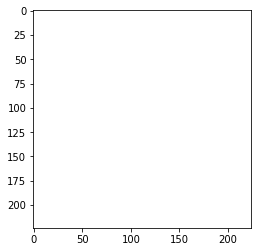

In [10]:
plt.imshow(x_train[2])

In [11]:
from keras.utils import np_utils

y_train = np_utils.to_categorical(y_train)
print(x_train.shape,y_train.shape)

(148, 224, 224, 3) (148, 2)


In [12]:
from keras.preprocessing.image import ImageDataGenerator
augment = ImageDataGenerator( 
                              rotation_range=20,
                              width_shift_range=0.01, 
                              height_shift_range=0.01, 
                              horizontal_flip=False, 
                              vertical_flip=False,
                            )
augment.fit(x_train)

In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2

In [14]:
model = Sequential()


model.add(Conv2D(filters=16, kernel_size=(3,3),input_shape=(224,224,3), activation='relu',kernel_regularizer=l2(0.01)))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(224,224,3), activation='relu',kernel_regularizer=l2(0.01)))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(224,224,3), activation='relu',kernel_regularizer=l2(0.01)))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(224,224,3), activation='relu',kernel_regularizer=l2(0.01)))
model.add(MaxPool2D(pool_size=(2, 2)))


model.add(Flatten())

model.add(Dense(224))

2022-07-10 12:18:28.983151: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [15]:
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(2))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        3

In [16]:
filepath="covid_detection.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True, mode='max',patience=3)
callbacks_list = [checkpoint]

In [17]:
hist = model.fit(x_train,y_train,
                    batch_size=64,
                    epochs = 20,
                    validation_split = 0.10,callbacks=callbacks_list)

2022-07-10 12:18:29.479310: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
3/3 [==============================] - 3s 614ms/step - loss: 46.5429 - accuracy: 0.4135 - val_loss: 8.4288 - val_accuracy: 0.4667

Epoch 00001: val_accuracy improved from -inf to 0.46667, saving model to covid_detection.hdf5
Epoch 2/20
3/3 [==============================] - 1s 414ms/step - loss: 7.5060 - accuracy: 0.5338 - val_loss: 2.5882 - val_accuracy: 0.6667

Epoch 00002: val_accuracy improved from 0.46667 to 0.66667, saving model to covid_detection.hdf5
Epoch 3/20
3/3 [==============================] - 2s 420ms/step - loss: 2.6765 - accuracy: 0.6541 - val_loss: 3.4950 - val_accuracy: 0.6000

Epoch 00003: val_accuracy did not improve from 0.66667
Epoch 4/20
3/3 [==============================] - 1s 407ms/step - loss: 2.8664 - accuracy: 0.6466 - val_loss: 1.6755 - val_accuracy: 0.7333

Epoch 00004: val_accuracy improved from 0.66667 to 0.73333, saving model to covid_detection.hdf5
Epoch 5/20
3/3 [==============================] - 2s 406ms/step - loss: 1.7935 - accuracy: 0

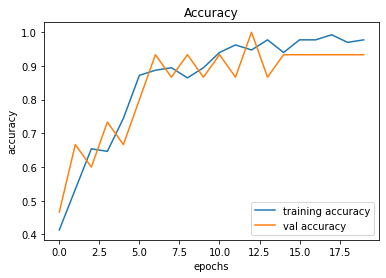

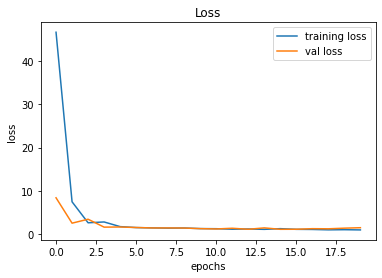

In [18]:
plt.figure(0)

plt.plot(hist.history['accuracy'], label='training accuracy')
plt.plot(hist.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(hist.history['loss'], label='training loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [19]:
test_images = "../input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/test"

test_image_data = []
test_labels = []

test_folders = os.listdir(test_images)
print(test_folders)

label_dict = {
    'PNEUMONIA':0,
    'NORMAL':1
}

from keras.preprocessing import image

for ix in test_folders:
    path = os.path.join(test_images,ix)
    for im in os.listdir(path):
        img = image.load_img(os.path.join(path,im),target_size = ((224,224)))
        img_array = image.img_to_array(img)
        test_image_data.append(img_array)
        test_labels.append(label_dict[ix])
        

combined = list(zip(test_image_data,test_labels))
test_image_data[:],test_labels[:] = zip(*combined)

x_test = np.array(test_image_data)
y_test = np.array(test_labels)

from keras.utils import np_utils

y_test = np_utils.to_categorical(y_test)
print(x_test.shape,y_test.shape)

['PNEUMONIA', 'NORMAL']
(40, 224, 224, 3) (40, 2)


In [20]:
model.evaluate(x_test,y_test)

2/2 [==============================] - 0s 28ms/step - loss: 15.0763 - accuracy: 0.0000e+00


[15.076314926147461, 0.0]

In [21]:
predictions = model.predict(x_test, batch_size = 32)
pred = np.argmax(predictions, axis=1)

In [22]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(test_labels, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      20.0
           1       0.00      0.00      0.00      20.0

    accuracy                           0.00      40.0
   macro avg       0.00      0.00      0.00      40.0
weighted avg       0.00      0.00      0.00      40.0



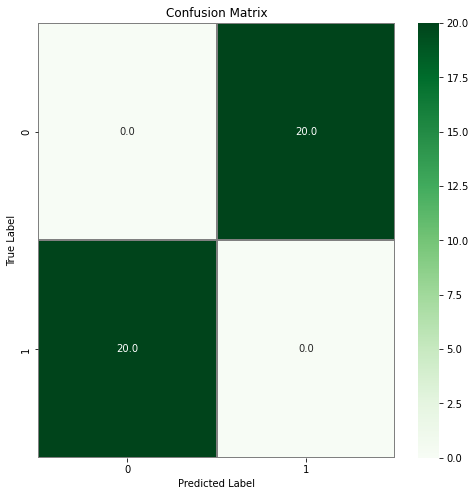

In [23]:
import seaborn as sns

Y_pred = model.predict(x_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [24]:
def img_plot(arr,index=0):
    plt.title('Test Image')
    plt.imshow(arr[index])

In [25]:

index1 = 30
input1 = x_test[index1:index1+1]
cnn_pred1 = model.predict(input1)[0].argmax()
label1 = y_test[index1].argmax()
print('Predicted Value using  cnn model',cnn_pred1)
print("\nTrue Value",label1)

Predicted Value using  cnn model 0

True Value 1
